# Trump Tweets Text Analysis






![](https://www.motherjones.com/wp-content/uploads/2020/03/trumpstrology-master_2000_gm.jpg?w=990)

For our text analysis we're using all 30,385 Trump tweets as of 1/27/2017. Data available [here](https://data.world/lovesdata/trump-tweets-5-4-09-12-5-16). 


We will cover his general pattern of tweeting, look for the most frequent used words, look into the sentiment and subjectivity of his tweets and also how was the landscape of his tweets different in different periods of his political life.

Team members:
  - Chowdhury Ashek Bin Helal
  - Lenka Krenkova
  - Prabhat Shrestha
  
  ...and Donald Trump



In [ ]:
import re
import io
import cv2
import nltk
import string
import matplotlib
import numpy as np
import pandas as pd
import altair as alt 
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
nltk.download()
#needed to be downloaded, so we get needed libraries, for example the english stopwords

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package brown to /root/nltk_data...
       |   Package brown is already up-to-date!
       | Downloading package brown_tei to /root/nltk_data...
       |   Package brown_tei is already up-to-date!
       | Downloading package cess_cat to /root/nltk_data...
       |   Package cess_cat is already up-to-date!
       | Down

True

In [ ]:
#loading the file
from google.colab import files
uploaded = files.upload()

Saving 2017_01_28 - Trump Tweets.xlsx to 2017_01_28 - Trump Tweets (1).xlsx


In [ ]:
import io
df = pd.read_excel(io.BytesIO(uploaded['2017_01_28 - Trump Tweets.xlsx']),parse_dates=[[0,1]])

In [ ]:
# set the date as index
df = df.set_index(['Date_Time'])
df.head()

,Tweet,Client,Client Simplified
Date_Time,,,
2017-01-27 18:46:22,I promise that our administration will ALWAYS...,Twitter for iPhone,Twitter for iPhone
2017-01-27 17:00:47,Congratulations Secretary Mattis! https://t.c...,Twitter for iPhone,Twitter for iPhone
2017-01-27 15:20:15,Statement on International Holocaust Remembra...,Twitter for iPhone,Twitter for iPhone
2017-01-27 11:30:29,.@VP Mike Pence will be speaking at today's #...,Twitter for iPhone,Twitter for iPhone
2017-01-27 11:27:02,The #MarchForLife is so important. To all of ...,Twitter for iPhone,Twitter for iPhone


In [ ]:
print(df.index.min())
print(df.index.max())

2009-05-04 14:54:25
2017-01-27 18:46:22


We have Trump Tweets from period between 4.5.2009 to 27.1.2017.

In [ ]:
# Cheaking the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30385 entries, 2017-01-27 18:46:22 to 2009-05-04 14:54:25
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Tweet              30385 non-null  object
 1   Client             30385 non-null  object
 2   Client Simplified  30385 non-null  object
dtypes: object(3)
memory usage: 949.5+ KB


In [ ]:
#checking the Client and Client Simplified are same
(df['Client']==df['Client Simplified']).all()

False

In [ ]:
#checking the differences between Client and Client Simplified with crosstabs
client_crosstab = pd.crosstab(df['Client'],df['Client Simplified'],values=df['Client'].count,aggfunc='count')
client_crosstab

Client Simplified,Other,Twitter Web Client,Twitter for Android,Twitter for iPhone
Client,,,,
Facebook,105.0,NaN,NaN,NaN
Instagram,133.0,NaN,NaN,NaN
Media Studio,1.0,NaN,NaN,NaN
Mobile Web (M5),56.0,NaN,NaN,NaN
Neatly For BlackBerry 10,5.0,NaN,NaN,NaN
Periscope,7.0,NaN,NaN,NaN
TweetDeck,483.0,NaN,NaN,NaN
TwitLonger Beta,405.0,NaN,NaN,NaN
Twitlonger,23.0,NaN,NaN,NaN


As the Client has more categories, that are grouped into 'other' in Cliend simplfied column, we're going to drop the Client column to simplify the dataset.

In [ ]:
#dropping the Client column
df.drop('Client',axis=1,inplace=True)
df.head()

,Tweet,Client Simplified
Date_Time,,
2017-01-27 18:46:22,I promise that our administration will ALWAYS...,Twitter for iPhone
2017-01-27 17:00:47,Congratulations Secretary Mattis! https://t.c...,Twitter for iPhone
2017-01-27 15:20:15,Statement on International Holocaust Remembra...,Twitter for iPhone
2017-01-27 11:30:29,.@VP Mike Pence will be speaking at today's #...,Twitter for iPhone
2017-01-27 11:27:02,The #MarchForLife is so important. To all of ...,Twitter for iPhone


# Calculating polarity and subjectivity

**Sentiment analysis** is the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

**Polarity** is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.


**Subjective analysis** is where the feeling of the individual taking part in the analysis process determines the outcome. ( knowledgetransfer.net) Subjective information or writing is based on personal opinions, interpretations, points of view, emotions and judgement.

**Subjective sentences** generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

For better readability we are rounding these two concepts up to two decimals.

In [ ]:
# For sentement polarity we don't have the date_time as an index.
df = df.reset_index() 
from textblob import TextBlob
Senti_polarity = []
for row in df['Tweet']:
    polarity = TextBlob(row)
    i = polarity.sentiment
    Senti_polarity.append(i)
Senti_polarity= pd.DataFrame(Senti_polarity)
print(Senti_polarity.head())
df = pd.concat([df, Senti_polarity], axis=1, sort=False)
df['polarity']=df['polarity'].apply(lambda x:round(x,2))
df['subjectivity']=df['subjectivity'].apply(lambda x:round(x,2))

## Printing needs to revise

print("Netural emotion in Tweet : {} with '0' polarity".format(df.polarity[df['polarity'] == 0].count()));
print("Positive emotion in Tweet : ", (df.polarity[df['polarity'] > 0].count()));
print("Negative emotion in Tweet : ", (df.polarity[df['polarity'] < 0].count()));
print("\n")
print("Subjective statement : ", (df.subjectivity[df['subjectivity'] >0.5].count()));
print("Non-Subjective statement : ", (df.subjectivity[df['subjectivity'] <= 0.5].count()));
print("Non-Subjective statement reflects that mostly the opinion and statement are not subjected to perticular, person, place or object and speech is factual information.");


   polarity  subjectivity
0   0.00000         0.000
1   0.00000         0.000
2   0.00000         0.000
3   0.43750         0.550
4   0.41875         0.775
Netural emotion in Tweet : 8757 with '0' polarity
Positive emotion in Tweet :  16814
Negative emotion in Tweet :  4814


Subjective statement :  12402
Non-Subjective statement :  17983
Non-Subjective statement reflects that mostly the opinion and statement are not subjected to perticular, person, place or object and speech is factual information.


# Descriptive analysis

## Checking for some of his top hits frequency, like China, Hillary Clinton or Trump himself:

In [ ]:
print('No. of Tweets on China : ', len(df[df['Tweet'].str.contains(r'[Cc]hina')]))
print('No. of times Trump mentioned in Tweets  : ', len(df[df['Tweet'].str.contains(r'[Tt]rump')]))
print('No. of times Donald Trump mentioned in Tweets  : ', len(df[df['Tweet'].str.contains(r'Donald Trump')]))
print('No. of times Donald J. Trump mentioned in Tweets  : ', len(df[df['Tweet'].str.contains(r'Donald J. Trump')]))
print('No. of times Hillary or Clinton mentioned in Tweets  : ', len(df[df['Tweet'].str.contains(r'[Hh]illary')]))
print('No. of times Clinton mentioned in Tweets  : ', len(df[df['Tweet'].str.contains(r'[Cc]linton')]))

No. of Tweets on China :  410
No. of times Trump mentioned in Tweets  :  12959
No. of times Donald Trump mentioned in Tweets  :  1043
No. of times Donald J. Trump mentioned in Tweets  :  71
No. of times Hillary or Clinton mentioned in Tweets  :  786
No. of times Clinton mentioned in Tweets  :  491


## Checking for the maximum of tweets in one day


In [ ]:
df = df.set_index(['Date_Time'])
day_count = df.resample('D').count()
print(day_count.Tweet.idxmax())
print(day_count.Tweet.max())

2015-01-05 00:00:00
169


## Checking for prime time of his tweets

In [ ]:
df['polarity_cat'] = 'Negative'
df.loc[(df['polarity'] == 0.00), 'polarity_cat'] = 'Neutral'
df.loc[(df['polarity'] > 0.00), 'polarity_cat'] = 'Positive'
df['subjectivity_cat'] = 'Non-Subjective'
df.loc[(df['subjectivity'] > 0.50), 'subjectivity_cat'] = 'Subjective'
df.head(10)

,Tweet,Client Simplified,polarity,subjectivity,polarity_cat,subjectivity_cat
Date_Time,,,,,,
2017-01-27 18:46:22,I promise that our administration will ALWAYS...,Twitter for iPhone,0.00,0.00,Neutral,Non-Subjective
2017-01-27 17:00:47,Congratulations Secretary Mattis! https://t.c...,Twitter for iPhone,0.00,0.00,Neutral,Non-Subjective
2017-01-27 15:20:15,Statement on International Holocaust Remembra...,Twitter for iPhone,0.00,0.00,Neutral,Non-Subjective
2017-01-27 11:30:29,.@VP Mike Pence will be speaking at today's #...,Twitter for iPhone,0.44,0.55,Positive,Subjective
2017-01-27 11:27:02,The #MarchForLife is so important. To all of ...,Twitter for iPhone,0.42,0.78,Positive,Subjective
2017-01-27 08:19:10,Mexico has taken advantage of the U.S. for lo...,Twitter for Android,-0.17,0.64,Negative,Subjective
2017-01-27 08:12:52,Look forward to seeing final results of VoteS...,Twitter for Android,-0.04,0.60,Negative,Subjective
2017-01-26 18:53:37,Miami-Dade Mayor drops sanctuary policy. Righ...,Twitter for iPhone,0.41,0.63,Positive,Subjective
2017-01-26 18:45:28,Will be interviewed by @SeanHannity on @FoxNe...,Twitter for iPhone,0.50,0.50,Positive,Non-Subjective


In [ ]:
#resampling with 4h frequency
count_4_h = df.resample('4h').count()
count_4_h

,Tweet,Client Simplified,polarity,subjectivity,polarity_cat,subjectivity_cat
Date_Time,,,,,,
2009-05-04 12:00:00,1,1,1,1,1,1
2009-05-04 16:00:00,0,0,0,0,0,0
2009-05-04 20:00:00,1,1,1,1,1,1
2009-05-05 00:00:00,0,0,0,0,0,0
2009-05-05 04:00:00,0,0,0,0,0,0
...,...,...,...,...,...,...
2017-01-27 00:00:00,0,0,0,0,0,0
2017-01-27 04:00:00,0,0,0,0,0,0
2017-01-27 08:00:00,4,4,4,4,4,4


In [ ]:
#table of total number of his Tweets in the 4h slots
table_count = count_4_h.groupby(count_4_h.index.hour).sum()
table_count = table_count.drop(['Client Simplified','polarity','subjectivity','polarity_cat','subjectivity_cat'], axis=1)
def highlight_max(s):
    '''
    highlight the maximum in a Series lightcoral.
    '''
    is_max = s == s.max()
    return ['background-color: lightcoral' if v else '' for v in is_max]

table_count.style.apply(highlight_max)  

,Tweet
Date_Time,
0,1863
4,2720
8,5971
12,7528
16,6577
20,5726


His prime time Tweeting is happening bewteen 12:00 and 16:00.

Let's check for the mean and plot the prime time.

In [ ]:
table_count['Time_range'] = ['00-04','04-08','08-12','12-16','16-20','20-24']
mean_tweets = table_count['Tweet'].mean()
#table_count['Mean'] = np.repeat(mean_tweets,6)
print(mean_tweets)

5064.166666666667


In [ ]:
table_count = table_count.set_index(['Time_range'])
table_count

,Tweet
Time_range,
00-04,1863
04-08,2720
08-12,5971
12-16,7528
16-20,6577
20-24,5726


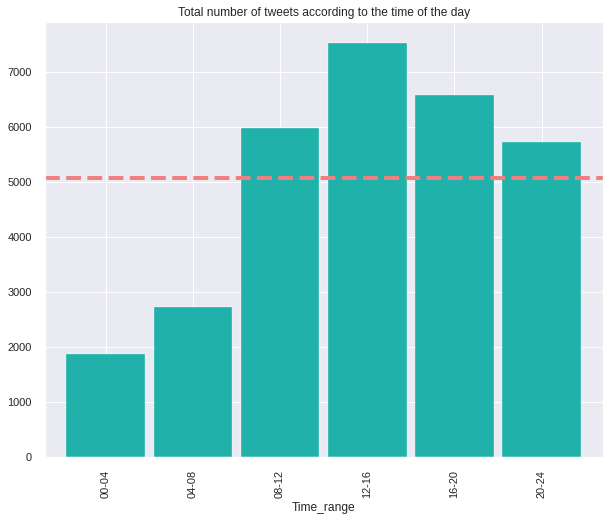

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 8))
sns.set(color_codes=True)
plt.style.use('seaborn')
table_count['Tweet'].plot(kind='bar',title='Total number of tweets according to the time of the day',y='Tweet',x = 'Time_range',width=0.9, color='lightseagreen' )
plt.axhline(mean_tweets,color='lightcoral',lw=4,ls='--')
#table_count['Mean'].plot(x='Time_rang',y = 'Mean',label='Mean', linestyle='--')

## Polarity and subjectivity distribution plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  """


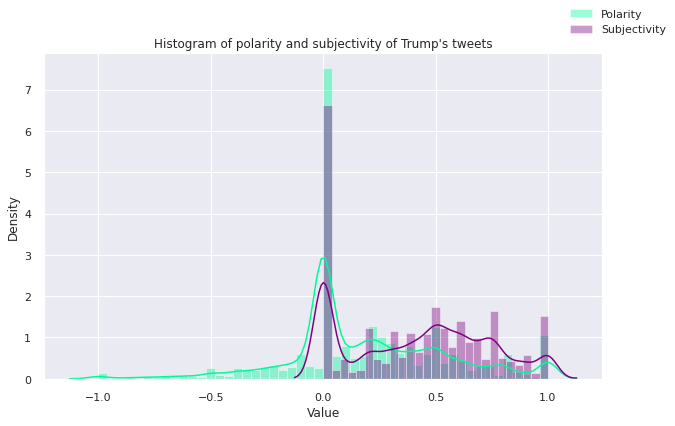

In [ ]:
sns.set(color_codes=True)
fig = plt.figure(figsize=(10,6))
sns.distplot(df.polarity, color='mediumspringgreen', norm_hist=True)
sns.distplot(df.subjectivity, color='purple',norm_hist=True)
fig.legend(labels=['Polarity','Subjectivity'], loc='best')
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram of polarity and subjectivity of Trump's tweets")
plt.show()

## Correlation between polarity and subjectivity

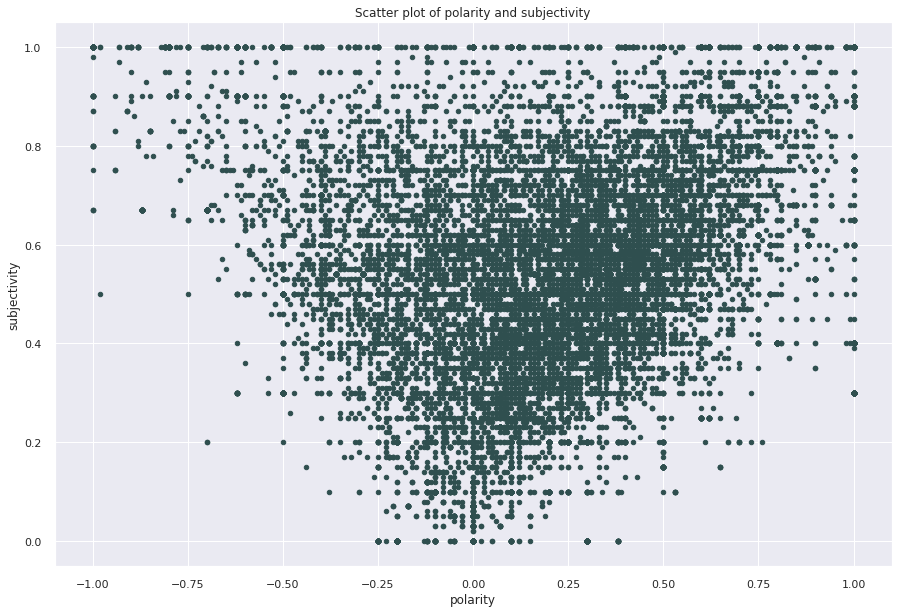

In [ ]:
df.plot.scatter('polarity','subjectivity', title='Scatter plot of polarity and subjectivity',figsize=(15,10),color='darkslategrey')

In [ ]:
df.corr()

,polarity,subjectivity
polarity,1.000000,0.328316
subjectivity,0.328316,1.000000


From the table and scatter plot we can see, that there's no significant correlation between polarity and subjectivity of Trump's tweets.

## Polarity of the tweets according to the time of the day.

In [ ]:
mean_4_h = df.resample('4h').mean()
mean_4_h['polarity_cat'] = 'Neutral'
mean_4_h.loc[(mean_4_h['polarity'] < 0.00), 'polarity_cat'] = 'Negative'
mean_4_h.loc[(mean_4_h['polarity'] > 0.00), 'polarity_cat'] = 'Positive'
mean_4_h.tail(10)

,polarity,subjectivity,polarity_cat
Date_Time,,,
2017-01-26 04:00:00,-0.6900,0.8100,Negative
2017-01-26 08:00:00,-0.0500,0.7900,Negative
2017-01-26 12:00:00,0.0000,0.0000,Neutral
2017-01-26 16:00:00,0.4550,0.5650,Positive
2017-01-26 20:00:00,NaN,NaN,Neutral
2017-01-27 00:00:00,NaN,NaN,Neutral
2017-01-27 04:00:00,NaN,NaN,Neutral
2017-01-27 08:00:00,0.1625,0.6425,Positive
2017-01-27 12:00:00,0.0000,0.0000,Neutral


In [ ]:
table_mean = mean_4_h.groupby([mean_4_h.index.hour,'polarity_cat']).mean()
table_mean

polarity  subjectivity
Date_Time polarity_cat                        
0         Negative     -0.259458      0.520363
          Neutral       0.000000      0.096222
          Positive      0.341210      0.473595
4         Negative     -0.191707      0.516060
          Neutral       0.000000      0.148956
          Positive      0.302006      0.464441
8         Negative     -0.168985      0.444297
          Neutral       0.000000      0.086142
          Positive      0.271835      0.471110
12        Negative     -0.134535      0.414677
          Neutral       0.000000      0.069043
          Positive      0.256013      0.439636
16        Negative     -0.165869      0.438321
          Neutral       0.000000      0.055875
          Positive      0.267005      0.442406
20        Negative     -0.164249      0.498364
          Neutral       0.000000      0.039783
          Positive      0.306201      0.468051

In [ ]:
table = pd.pivot_table(table_mean, values='polarity', index='Date_Time',
                    columns='polarity_cat', aggfunc='mean')
table['Time_range'] = ['00-04','04-08','08-12','12-16','16-20','20-24']
table

polarity_cat,Negative,Neutral,Positive,Time_range
Date_Time,,,,
0,-0.259458,0.0,0.341210,00-04
4,-0.191707,0.0,0.302006,04-08
8,-0.168985,0.0,0.271835,08-12
12,-0.134535,0.0,0.256013,12-16
16,-0.165869,0.0,0.267005,16-20
20,-0.164249,0.0,0.306201,20-24


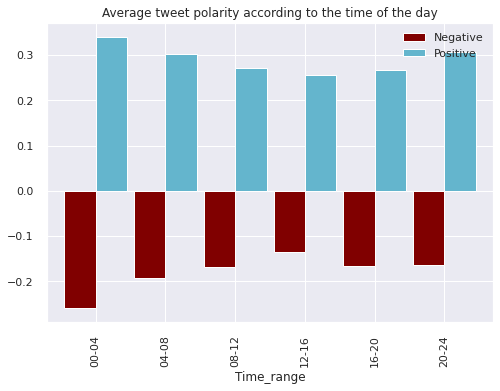

In [ ]:
table.plot(kind='bar',title='Average tweet polarity according to the time of the day',y=['Negative','Positive'],
                        x='Time_range' , width=0.9, color=['maroon','c'] )
plt.legend(loc=1)

# Cleaning before further calculations

- Like removing the stopwords

In [ ]:
df.Tweet = df.Tweet.apply(lambda x: x.lower())
df.Tweet = df.Tweet.apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
from textblob import TextBlob, Word
#data1.text= data1.text.apply(lambda x: str(TextBlob(x).correct()))
# BeautifulSoup
df.Tweet = df.Tweet.apply(lambda x: " ".join(x for x in x.split() if x not in stopwords.words('english') ))
df.Tweet = df.Tweet.apply(lambda x: ([x for x in x.split() if x.isalpha()]))
df.Tweet = df.Tweet.apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))
df.Tweet

Date_Time
2017-01-27 18:46:22            promise administration always back always
2017-01-27 17:00:47    congratulation secretary mattis httpstcomkuhbe...
2017-01-27 15:20:15    statement international holocaust remembrance day
2017-01-27 11:30:29    vp mike penny speaking today marchforlife full...
2017-01-27 11:27:02         marchforlife important marching full support
                                             ...                        
2009-05-12 10:07:28    persona never wallflower rather build wall cli...
2009-05-08 16:40:15    new blog post celebrity apprentice finale less...
2009-05-08 09:38:08    donald trump read top ten financial tip late s...
2009-05-04 21:00:10    donald trump appearing view tomorrow morning d...
2009-05-04 14:54:25    sure tune watch donald trump late night david ...
Name: Tweet, Length: 30385, dtype: object

# Splitting the dataset:

We have the couple of important dates that could shape the landscape of Trump's tweets:
- his 2016 presidential campaign formally launched on **June 16, 2015**
- he won the U.S. presidential election on **November 9, 2016**

We assume that his tweets, both negative and positive, will be different in the three periods:
1. Before running for president
2. During his presidential campaign
3. During his presidency



- 'Fun' facts 
  - He already ran for president in 2000, but withdrew from the race
  - He registered as a Republican in Manhattan in 1987, switched to the Reform Party in 1999, the Democratic Party in 2001, and back to the Republican Party in 2009.

In [ ]:
#df = df.set_index(df['Date_Time'])
# create train test partition
bef_campaign = df[:'2016-06-15']
pos_bef_campaign = bef_campaign[bef_campaign['polarity'] > 0.00]
neg_bef_campaign = bef_campaign[bef_campaign['polarity'] < 0.00]
campaign  = df['2016-06-16':'2016-11-08']
pos_campaign = campaign[campaign['polarity'] > 0.00]
neg_campaign = campaign[campaign['polarity'] < 0.00]
presidency = df['2016-11-09':]
pos_presidency = presidency[presidency['polarity'] > 0.00]
neg_presidency = presidency[presidency['polarity'] < 0.00]
print('Before running the campaign:',bef_campaign.shape)
print('During the campaign:',campaign.shape)
print('Presidency',presidency.shape)
print(presidency.head())

Before running the campaign: (28192, 6)
During the campaign: (1771, 6)
Presidency (422, 6)
                                                                 Tweet  ... subjectivity_cat
Date_Time                                                               ...                 
2017-01-27 18:46:22          promise administration always back always  ...   Non-Subjective
2017-01-27 17:00:47  congratulation secretary mattis httpstcomkuhbe...  ...   Non-Subjective
2017-01-27 15:20:15  statement international holocaust remembrance day  ...   Non-Subjective
2017-01-27 11:30:29  vp mike penny speaking today marchforlife full...  ...       Subjective
2017-01-27 11:27:02       marchforlife important marching full support  ...       Subjective

[5 rows x 6 columns]


In [ ]:
positive_Tweet = df[df['polarity'] > 0]
print('Positive Tweet : \n', positive_Tweet.head())
negative_Tweet = df[df['polarity'] < 0]
print('Negative Tweet : \n', negative_Tweet.head())
negative_Tweet.shape

Positive Tweet : 
                                                                  Tweet  ... subjectivity_cat
Date_Time                                                               ...                 
2017-01-27 11:30:29  vp mike penny speaking today marchforlife full...  ...       Subjective
2017-01-27 11:27:02       marchforlife important marching full support  ...       Subjective
2017-01-26 18:53:37  miamidade mayor drop sanctuary policy right de...  ...       Subjective
2017-01-26 18:45:28      interviewed seanhannity foxnews tonight enjoy  ...   Non-Subjective
2017-01-25 21:48:25         interview david muir abc news minute enjoy  ...   Non-Subjective

[5 rows x 6 columns]
Negative Tweet : 
                                                                  Tweet  ... subjectivity_cat
Date_Time                                                               ...                 
2017-01-27 08:19:10  mexico taken advantage u long enough massive t...  ...       Subjective
2017-01-27

(4814, 6)

# WordClouds

In [ ]:
from collections import Counter
from itertools import chain
counter = Counter(chain.from_iterable(map(str.split, negative_Tweet.Tweet.tolist())))
neg_tweet_list = pd.Series(counter).sort_values(ascending=False)

In [ ]:
def wordcloud_plot(data,color):
  def wordcloud_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None,color=color):
    if color == 'pos':
      h = 140
    elif color == 'neu':
      h = 35  
    else:
      h = 21  
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
  img = cv2.imread('/content/drive/My Drive/png-clipart-donald-trump-art-cartoon-donald-trump-celebrities-face.png')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  wc = WordCloud(background_color="black",color_func=wordcloud_color, max_words=150, mask=img )
  wc.generate(data)
  # create coloring from image
  #image_colors = ImageColorGenerator(mask)
  plt.figure(figsize=[16,9])
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()
  #plt.imshow(mask)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The whole dataset

## Overall negative tweets

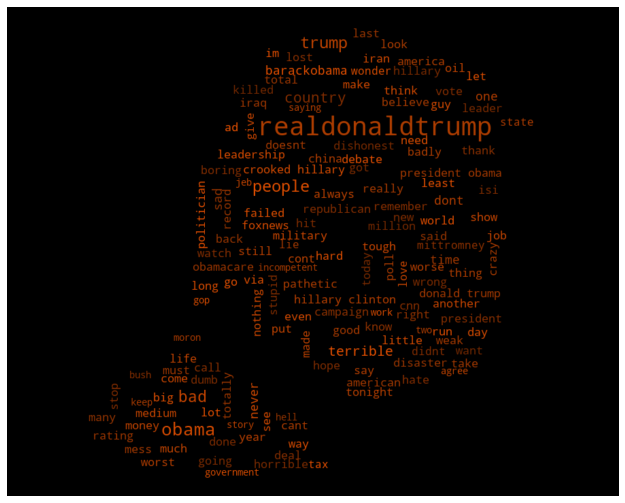

Subjective statement :  2632
Non-Subjective statement :  2182


In [ ]:
word_lists = negative_Tweet.Tweet
neg_unique  = ' '.join(word_lists)
wordcloud_plot(neg_unique,'neg')
print("Subjective statement : ", (negative_Tweet['subjectivity'][negative_Tweet['subjectivity'] >0.5].count()))
print("Non-Subjective statement : ", (negative_Tweet['subjectivity'][negative_Tweet['subjectivity'] <= 0.5].count()))

## Overall positive tweets

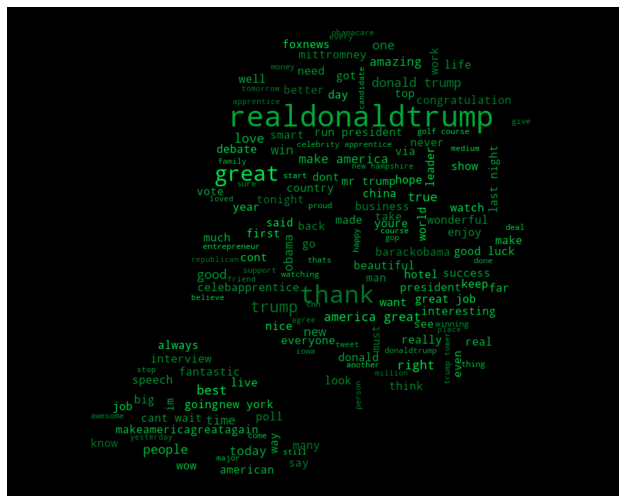

Subjective statement :  9241
Non-Subjective statement :  7573


In [ ]:
counter = Counter(chain.from_iterable(map(str.split, positive_Tweet.Tweet.tolist())))
pos_tweet_list = pd.Series(counter).sort_values(ascending=False)
word_lists = positive_Tweet.Tweet
pos_unique  = ' '.join(word_lists)
wordcloud_plot(pos_unique,'pos')

print("Subjective statement : ", (positive_Tweet['subjectivity'][positive_Tweet['subjectivity'] >0.5].count()))
print("Non-Subjective statement : ", (positive_Tweet['subjectivity'][positive_Tweet['subjectivity'] <= 0.5].count()))

# Tweets before campaign

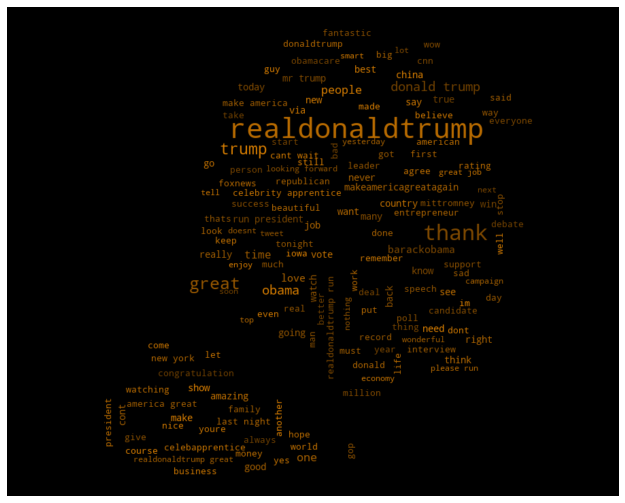

realdonaldtrump    8266
trump              4146
great              3447
thanks             1960
president          1726
thank              1637
donald             1481
u                  1423
get                1221
would              1191
like               1174
people             1156
need               1137
obama              1130
new                1092
dtype: int64



Netural emotion in Tweet : 8013 with '0' polarity
Positive emotion in Tweet :  15861
Negative emotion in Tweet :  4318


Subjective statement :  11581
Non-Subjective statement :  16611


In [ ]:
counter = Counter(chain.from_iterable(map(str.split, bef_campaign.Tweet.tolist())))
bef_campaign_list = pd.Series(counter).sort_values(ascending=False)

word_lists = bef_campaign.Tweet
bef_campaign_unique = ' '.join(word_lists)
wordcloud_plot(bef_campaign_unique,'neu')
print(bef_campaign_list[:15])
print("\n\n")
print("Netural emotion in Tweet : {} with '0' polarity".format(bef_campaign.polarity[bef_campaign['polarity'] == 0].count()))
print("Positive emotion in Tweet : ", (bef_campaign.polarity[bef_campaign['polarity'] > 0].count()))
print("Negative emotion in Tweet : ", (bef_campaign.polarity[bef_campaign['polarity'] < 0].count()))
print("\n")
print("Subjective statement : ", (bef_campaign.subjectivity[bef_campaign['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (bef_campaign.subjectivity[bef_campaign['subjectivity'] <= 0.5].count()))

## Positive tweets before campaign

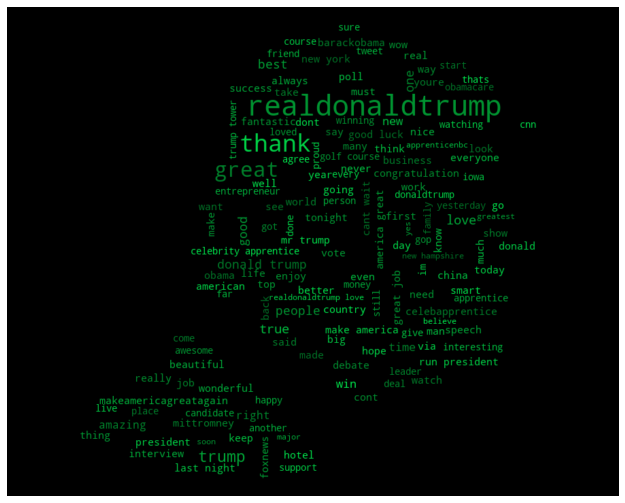

Subjective statement :  8717
Non-Subjective statement :  7144





In [ ]:
counter = Counter(chain.from_iterable(map(str.split, pos_bef_campaign.Tweet.tolist())))
pos_bef_campaign_list = pd.Series(counter).sort_values(ascending=False)
pos_bef_word_lists = pos_bef_campaign.Tweet
pos_bef_campaign_unique  = ' '.join(pos_bef_word_lists)
print("\n")
wordcloud_plot(pos_bef_campaign_unique,'pos')
print("Subjective statement : ", (pos_bef_campaign.subjectivity[pos_bef_campaign['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (pos_bef_campaign.subjectivity[pos_bef_campaign['subjectivity'] <= 0.5].count()))
print("\n\n")

## Negative tweets before campaign

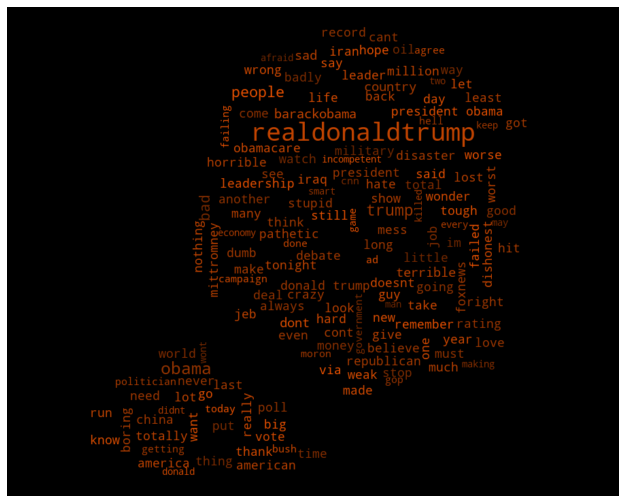



Subjective statement :  2371
Non-Subjective statement :  1947


In [ ]:
counter = Counter(chain.from_iterable(map(str.split, neg_bef_campaign.Tweet.tolist())))
neg_bef_campaign_list = pd.Series(counter).sort_values(ascending=False)
neg_bef_word_lists = neg_bef_campaign.Tweet
neg_bef_campaign_unique  = ' '.join(neg_bef_word_lists)
wordcloud_plot(neg_bef_campaign_unique,'neg')
print("\n")
print("Subjective statement : ", (neg_bef_campaign.subjectivity[neg_bef_campaign['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (neg_bef_campaign.subjectivity[neg_bef_campaign['subjectivity'] <= 0.5].count()))

# Tweets during campaign

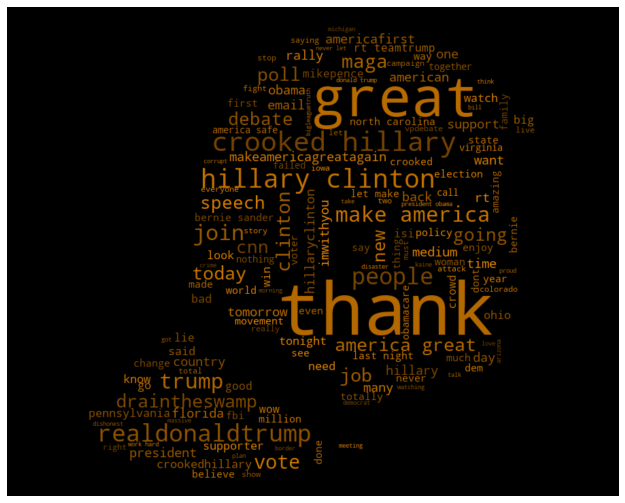

hillary            312
thank              258
great              227
clinton            226
crooked            156
america            134
trump              130
make               122
people             121
join               113
realdonaldtrump    109
rt                 105
get                 97
debate              94
maga                90
dtype: int64



Netural emotion in Tweet : 646 with '0' polarity
Positive emotion in Tweet :  729
Negative emotion in Tweet :  396


Subjective statement :  614
Non-Subjective statement :  1157


In [ ]:
counter = Counter(chain.from_iterable(map(str.split, campaign.Tweet.tolist())))
campaign_list = pd.Series(counter).sort_values(ascending=False)
word_lists = campaign.Tweet
campaign_unique = ' '.join(word_lists)
wordcloud_plot(campaign_unique,'neu')
print(campaign_list[:15])

print("\n\n")
print("Netural emotion in Tweet : {} with '0' polarity".format(campaign.polarity[campaign['polarity'] == 0].count()))
print("Positive emotion in Tweet : ", (campaign.polarity[campaign['polarity'] > 0].count()))
print("Negative emotion in Tweet : ", (campaign.polarity[campaign['polarity'] < 0].count()))
print("\n")
print("Subjective statement : ", (campaign.subjectivity[campaign['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (campaign.subjectivity[campaign['subjectivity'] <= 0.5].count()))

## Positive tweets during campaign

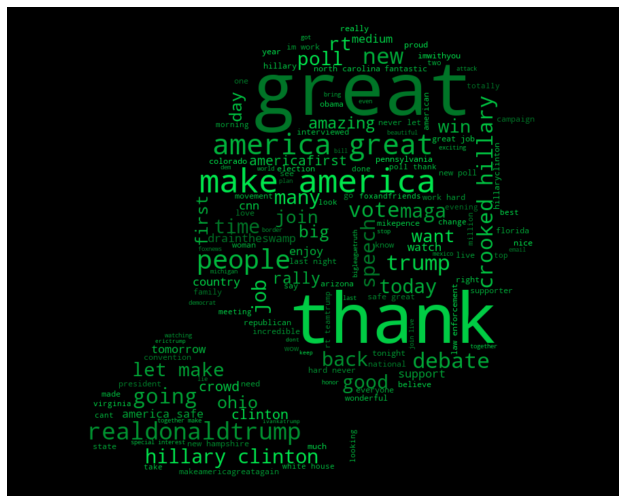



Subjective statement :  384
Non-Subjective statement :  345





In [ ]:
counter = Counter(chain.from_iterable(map(str.split, pos_campaign.Tweet.tolist())))
pos_campaign_list = pd.Series(counter).sort_values(ascending=False)
pos_be_word_lists = pos_campaign.Tweet
pos_campaign_unique  = ' '.join(pos_be_word_lists)
wordcloud_plot(pos_campaign_unique,'pos')

print("\n")
print("Subjective statement : ", (pos_campaign.subjectivity[pos_campaign['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (pos_campaign.subjectivity[pos_campaign['subjectivity'] <= 0.5].count()))
print("\n\n")

## Negative tweets during campaing

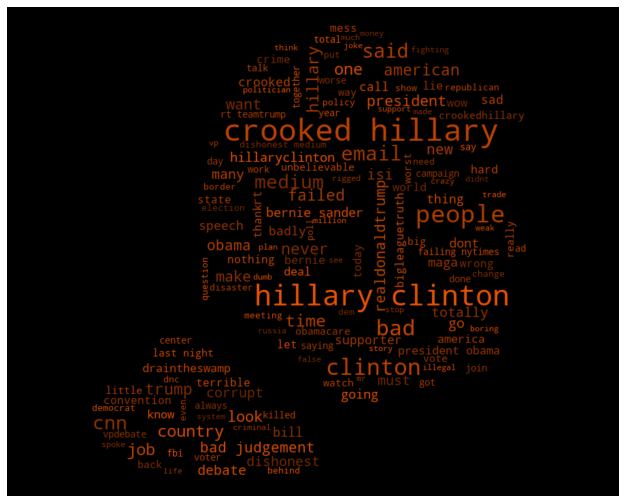



Subjective statement :  200
Non-Subjective statement :  196


In [ ]:
counter = Counter(chain.from_iterable(map(str.split, neg_campaign.Tweet.tolist())))
neg_campaign_list = pd.Series(counter).sort_values(ascending=False)
neg_C_word_lists = neg_campaign.Tweet
neg_campaign_unique  = ' '.join(neg_C_word_lists)
wordcloud_plot(neg_campaign_unique,'neg')

print("\n")
print("Subjective statement : ", (neg_campaign.subjectivity[neg_campaign['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (neg_campaign.subjectivity[neg_campaign['subjectivity'] <= 0.5].count()))

# After elected as President

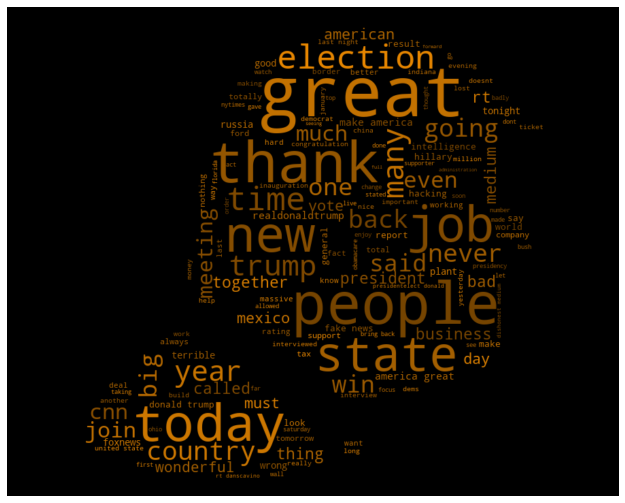

great       72
u           48
people      40
trump       35
state       34
thank       32
today       31
job         28
election    27
make        27
time        26
would       26
back        25
many        22
new         21
dtype: int64



Netural emotion in Tweet : 98 with '0' polarity
Positive emotion in Tweet :  224
Negative emotion in Tweet :  100


Subjective statement :  207
Non-Subjective statement :  79


In [ ]:
counter = Counter(chain.from_iterable(map(str.split, presidency.Tweet.tolist())))
presidency_list = pd.Series(counter).sort_values(ascending=False)

word_lists = presidency.Tweet
presidency_unique = ' '.join(word_lists)
wordcloud_plot(presidency_unique,'neu')
print(presidency_list[:15])

print("\n\n")
print("Netural emotion in Tweet : {} with '0' polarity".format(presidency.polarity[presidency['polarity'] == 0].count()))
print("Positive emotion in Tweet : ", (presidency.polarity[presidency['polarity'] > 0].count()))
print("Negative emotion in Tweet : ", (presidency.polarity[presidency['polarity'] < 0].count()))
print("\n")
print("Subjective statement : ", (presidency.subjectivity[presidency['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (presidency.subjectivity[presidency['subjectivity'] <= 0].count()))

## Positive tweets during presidency

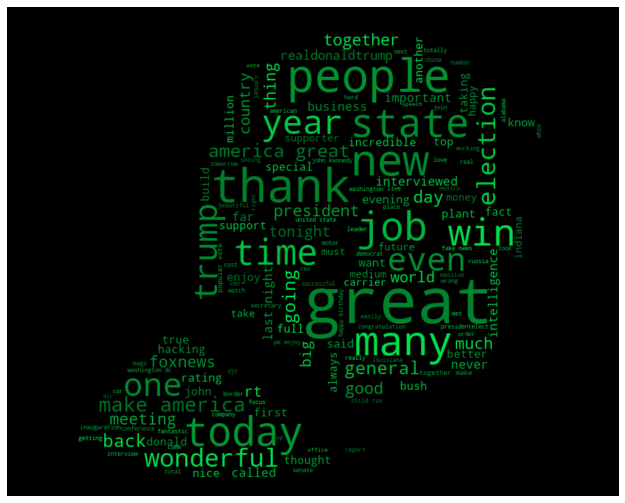



Subjective statement :  140
Non-Subjective statement :  84





In [ ]:
counter = Counter(chain.from_iterable(map(str.split, pos_presidency.Tweet.tolist())))
pos_Presd_list = pd.Series(counter).sort_values(ascending=False)
pos_Presd_word_lists = pos_presidency.Tweet
pos_Presd_unique  = ' '.join(pos_Presd_word_lists)

wordcloud_plot(pos_Presd_unique,'pos')

print("\n")
print("Subjective statement : ", (pos_presidency.subjectivity[pos_presidency['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (pos_presidency.subjectivity[pos_presidency['subjectivity'] <= 0.5].count()))
print("\n\n")

## Negative tweets during presidency

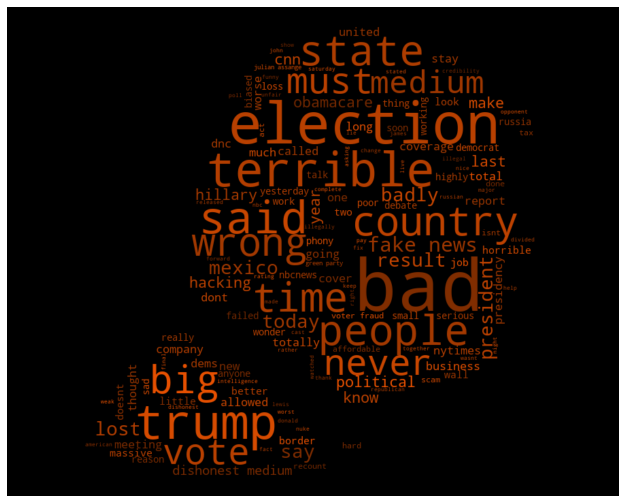



Subjective statement :  61
Non-Subjective statement :  39


In [ ]:
counter = Counter(chain.from_iterable(map(str.split, neg_presidency.Tweet.tolist())))
neg_Presd_list = pd.Series(counter).sort_values(ascending=False)
neg_Presd_word_lists = neg_presidency.Tweet
neg_Presd_unique  = ' '.join(neg_Presd_word_lists)

wordcloud_plot(neg_Presd_unique,'neg')

print("\n")
print("Subjective statement : ", (neg_presidency.subjectivity[neg_presidency['subjectivity'] > 0.5].count()))
print("Non-Subjective statement : ", (neg_presidency.subjectivity[neg_presidency['subjectivity'] <= 0.5].count()))